In [44]:
import os

import numpy as np
import pandas as pd

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import cv2
import scipy
import scipy.io

In [2]:
# Suppress warning and informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Get count of number of files in this folder and all subfolders
def get_num_files(path):
  if not os.path.exists(path):
    return 0
  return sum([len(files) for r, d, files in os.walk(path)])

In [4]:
# Get count of number of subfolders directly below the folder in path
def get_num_subfolders(path):
  if not os.path.exists(path):
    return 0
  return sum([len(d) for r, d, files in os.walk(path)])

In [5]:
#   Define image generators that will variations of image with the image r/otated slightly, shifted up, down, left, or right, 
#     sheared, zoomed in, or flipped horizontally on the vertical axis (ie. person looking to the left ends up looking to the right)
def create_img_generator():
  return  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      horizontal_flip=True
  )

In [6]:
# Main Code
Image_width, Image_height = 224, 224 
Training_Epochs = 256
Batch_Size = 32
Number_FC_Neurons = 1024

train_dir = r'./../Storage/train_filtered'
validate_dir = r'./../Storage/valid'
num_train_samples = get_num_files(train_dir) 
num_classes = get_num_subfolders(train_dir)
num_validate_samples = get_num_files(validate_dir)
num_epoch = Training_Epochs
batch_size = Batch_Size

In [7]:
# Define data pre-processing 
#   Define image generators for training and testing 
train_image_gen = create_img_generator()
test_image_gen = create_img_generator()

In [8]:
#   Connect the image generator to a folder contains the source images the image generator alters.  
#   Training image generator
train_generator = train_image_gen.flow_from_directory(
  train_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed = 42    #set seed for reproducability
)

Found 6473 images belonging to 102 classes.


In [9]:
#   Validation image generator
validation_generator = test_image_gen.flow_from_directory(
  validate_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed=42       #set seed for reproducability
)

Found 818 images belonging to 102 classes.


In [18]:
# Load the Inception V3 model and load it with it's pre-trained weights.  But exclude the final 
#    Fully Connected layer
#ResNet50_base_model = ResNet50(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
#print('ResNet50 base model without last FC loaded')
#print(ResNet50_base_model.summary())     # display the Inception V3 model hierarchy

c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


ResNet50 base model without last FC loaded


In [45]:
base_model = InceptionResNetV2(include_top=False, weights='imagenet') #, input_tensor=Input(shape=(224,224,3)), input_shape=(224,224,3))
  #model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
  #image_size = (224, 224)
print('MobileNet base model without last FC loaded')

219062272/219055592 [==============================] - 60s 0us/step
MobileNet base model without last FC loaded


In [46]:
# Define the layers in the new classification prediction 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(Number_FC_Neurons, activation='relu')(x)        # new FC layer, random init
predictions = Dense(num_classes, activation='softmax')(x)  # new softmax layer

In [47]:
# Define trainable model which links input from the Inception V3 base model to the new classification prediction layers
model = Model(inputs=base_model.input, outputs=predictions)

In [48]:
# print model structure diagram
print (model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_99 (Activation)      (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [49]:
# Option 1: Basic Transfer Learning
print ('\nPerforming Transfer Learning')
  #   Freeze all layers in the Inception V3 base model 
for layer in ResNet50_base_model.layers:
  layer.trainable = False


Performing Transfer Learning


In [50]:
#   Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
#Model Check point
checkpoint = ModelCheckpoint('unet_best_model_gray_imgs.h5',
                            monitor='va_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=100)

In [42]:
# Fit the transfer learning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from 
# the training or validation folders and alter them slightly
history_transfer_learning = model.fit_generator(
  train_generator,
  epochs=num_epoch,
  steps_per_epoch = num_train_samples // batch_size,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
  class_weight='auto',
  callbacks=[earlystopping, checkpoint])

Epoch 1/256
  6/202 [..............................] - ETA: 7:05 - loss: 5.1546 - accuracy: 0.0417

ResourceExhaustedError:  OOM when allocating tensor with shape[1024,1024,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node conv_pw_13/convolution (defined at c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_130211]

Function call stack:
keras_scratch_graph


dict_keys(['val_loss', 'accuracy', 'loss', 'val_accuracy'])


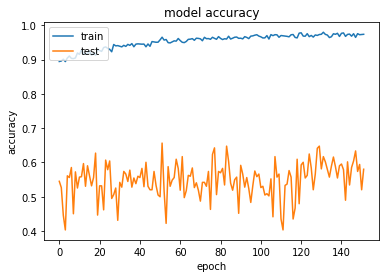

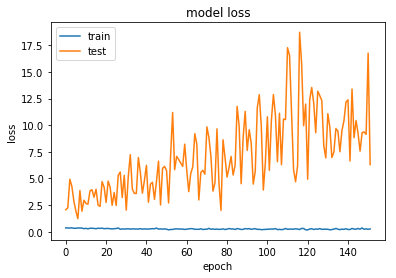

In [40]:
# list all data in history
print(history_transfer_learning.history.keys())
# summarize history for accuracy
plt.plot(history_transfer_learning.history['accuracy'])
plt.plot(history_transfer_learning.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# Save transfer learning model
model.save('ResNet50-transfer-learning_gray_imgs.model')

In [10]:
Training_Epochs = 1
num_epoch = Training_Epochs
#batch_size = Batch_Size

In [11]:
model = load_model('ResNet50-transfer-learning_gray_imgs.model')

In [12]:
len(model.layers)

178

In [13]:
# Option 2: Transfer Learning with Fine-tuning - retrain the end few layers (called the top layers) of the inception model
print('\nFine tuning existing model')
#   Freeze 
Layers_To_Freeze = 45
for layer in model.layers[:Layers_To_Freeze]:
  layer.trainable = False
for layer in model.layers[Layers_To_Freeze:]:
  layer.trainable = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


Fine tuning existing model


In [14]:
# Fit the Fine-tuning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from the training or validation
# folders, alter then slightly, and pass the images back
history_fine_tune = model.fit_generator(
  train_generator,
  steps_per_epoch = num_train_samples // batch_size,
  epochs=num_epoch,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
    class_weight='auto')

Epoch 1/1
204/204 [==============================] - 221s 1s/step - loss: 0.1241 - accuracy: 0.9900 - val_loss: 0.2345 - val_accuracy: 0.9000


In [15]:
# Save fine tuned model
model.save('ResNet50-fine-tune_gray_imgs_val_accuracy.model')

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


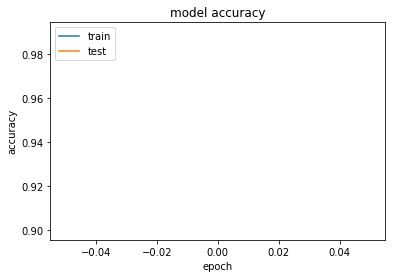

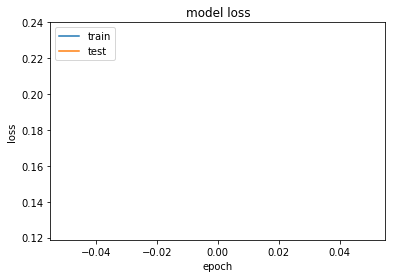

In [16]:
# list all data in history
print(history_fine_tune.history.keys())
# summarize history for accuracy
plt.plot(history_fine_tune.history['accuracy'])
plt.plot(history_fine_tune.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
#   Validation image generator
test_datagen = ImageDataGenerator()
test_dir = r'./../Storage/test'

In [18]:
#   Validation image generator
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(Image_width, Image_height),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 819 images belonging to 1 classes.


In [19]:
test_generator.reset()

In [20]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [21]:
pred=model.predict_generator(test_generator,verbose=1,steps = np.ceil(nb_samples/batch_size))

26/26 [==============================] - 13s 491ms/step


In [22]:
predicted_class_indices=np.argmax(pred,axis=1)

In [23]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [24]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [25]:
results

,Filename,Predictions
0,test\image_00005.jpg,77
1,test\image_00006.jpg,77
2,test\image_00024.jpg,77
3,test\image_00025.jpg,77
4,test\image_00029.jpg,77
...,...,...
814,test\image_08133.jpg,57
815,test\image_08134.jpg,57
816,test\image_08144.jpg,83
817,test\image_08172.jpg,84


In [26]:
type(results.Predictions.loc[1])

str

In [27]:
results.Predictions = results.Predictions.astype(np.int64)

In [28]:
type(results.Predictions.loc[1])

numpy.int64

In [29]:
results

,Filename,Predictions
0,test\image_00005.jpg,77
1,test\image_00006.jpg,77
2,test\image_00024.jpg,77
3,test\image_00025.jpg,77
4,test\image_00029.jpg,77
...,...,...
814,test\image_08133.jpg,57
815,test\image_08134.jpg,57
816,test\image_08144.jpg,83
817,test\image_08172.jpg,84


In [30]:
#oxford102_flower_dataset_labels.txt contains a dataset where index is the unique label and column "Names" is the name of the flower for the image label id 
#read labels from oxford102_flower_dataset_labels.txt
oxford102_labels = pd.read_csv('oxford102_flower_dataset_labels.txt', delimiter='\t', header=None, names=['Names'])
# Image labels are 1 based, changed the index of the image database label
oxford102_labels.index = np.arange(1, len(oxford102_labels) + 1)
print(oxford102_labels)
print()
print("Test Print: FLower Name and its unique label")
print(oxford102_labels.loc[77])

                            Names
1                 'pink primrose'
2     'hard-leaved pocket orchid'
3              'canterbury bells'
4                     'sweet pea'
5              'english marigold'
..                            ...
98              'mexican petunia'
99                     'bromelia'
100              'blanket flower'
101             'trumpet creeper'
102             'blackberry lily'

[102 rows x 1 columns]

Test Print: FLower Name and its unique label
Names     'passion flower'
Name: 77, dtype: object


In [31]:
oxford102_labels.reset_index(level=0, inplace=True)

In [32]:
oxford102_labels.head()

,index,Names
0,1,'pink primrose'
1,2,'hard-leaved pocket orchid'
2,3,'canterbury bells'
3,4,'sweet pea'
4,5,'english marigold'


In [33]:
oxford102_labels.rename({'index': 'Predictions'}, axis=1, inplace=True)

In [34]:
oxford102_labels.columns

Index(['Predictions', 'Names'], dtype='object')

In [35]:
merge_predictions = pd.merge(results, oxford102_labels, on='Predictions')

In [36]:
merge_predictions

,Filename,Predictions,Names
0,test\image_00005.jpg,77,'passion flower'
1,test\image_00006.jpg,77,'passion flower'
2,test\image_00024.jpg,77,'passion flower'
3,test\image_00025.jpg,77,'passion flower'
4,test\image_00029.jpg,77,'passion flower'
...,...,...,...
814,test\image_07936.jpg,100,'blanket flower'
815,test\image_07938.jpg,100,'blanket flower'
816,test\image_08004.jpg,102,'blackberry lily'
817,test\image_08015.jpg,102,'blackberry lily'


In [43]:
merge_predictions.loc[merge_predictions['Filename'] == 'test\image_07936.jpg']

,Filename,Predictions,Names
814,test\image_07936.jpg,100,'blanket flower'


In [50]:
oxford102_labels.loc[99]

Predictions                  100
Names           'blanket flower'
Name: 99, dtype: object

In [45]:
#imagelabels.mat contains labels of the images and number of images for each label
#labels and unique are the lists that contain the label ids and respective number of images 
mat = scipy.io.loadmat('imagelabels.mat')
labels = mat['labels'].tolist()
unique, counts = np.unique(labels, return_counts=True)

In [46]:
#find a flower label from flower image name
def find_flower_label_from_flower_image_name(flower_image_name):
    flower_id = flower_image_name.split('_')[1].split('.')[0]
    flower_id_int = int(flower_id)
    return labels[0][flower_id_int - 1]

In [60]:
#Find the name of the flower from the image name from the image database
def find_flower_category_name(file_path):
    flower_name = file_path.split("\\")[-1]
    flower_label = find_flower_label_from_flower_image_name(flower_name)
    flower_category_name = oxford102_labels.Names.loc[flower_label-1]
    return flower_category_name.replace("'", '').strip()

In [61]:
find_flower_category_name('test\image_07936.jpg')

'blanket flower'

In [53]:
test_images = results.Filename

In [56]:
type(test_images)

pandas.core.series.Series

In [62]:
list_actual_flower_name = []
for filename in test_images.items():
    actual_name = find_flower_category_name(filename[1])
    list_actual_flower_name.append(actual_name)

In [66]:
df = pd.DataFrame(list_actual_flower_name, columns = ['Actuals'])

In [68]:
merge_predictions['Actuals'] = list_actual_flower_name

In [69]:
merge_predictions

,Filename,Predictions,Names,Actuals
0,test\image_00005.jpg,77,'passion flower',passion flower
1,test\image_00006.jpg,77,'passion flower',passion flower
2,test\image_00024.jpg,77,'passion flower',passion flower
3,test\image_00025.jpg,77,'passion flower',passion flower
4,test\image_00029.jpg,77,'passion flower',passion flower
...,...,...,...,...
814,test\image_07936.jpg,100,'blanket flower',gaura
815,test\image_07938.jpg,100,'blanket flower',gaura
816,test\image_08004.jpg,102,'blackberry lily',gaura
817,test\image_08015.jpg,102,'blackberry lily',japanese anemone
